<a href="https://colab.research.google.com/github/elijahmflomo/Sem_2_GENERATIVE-AI/blob/main/LAB_1_DDPM_for_the_MNIST_Dataset_%E2%80%93_Image_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run only if needed (Colab usually has these)
!pip install torch torchvision scikit-learn tqdm matplotlib


Install & Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


transform = transforms.Compose([
    transforms.ToTensor(),              # Converts image → tensor
    transforms.Normalize((0.5,), (0.5,)) # Scales values between -1 and 1
])


train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

#Loads MNIST images in batches (faster training)#


STEP 2: Diffusion Process (Adding Noise)

In [ ]:
T = 1000  # total steps
beta = torch.linspace(1e-4, 0.02, T).to(device)

alpha = 1 - beta
alpha_hat = torch.cumprod(alpha, dim=0) #Keeps track of how much original image remains#

def forward_diffusion(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    xt = sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise
    return xt, noise




STEP 3: Reverse Process (U-Net Model)

In [ ]:
#Time Embedding#

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.embedding = nn.Embedding(T, dim)

    def forward(self, t):
        return self.embedding(t)

# Simple U-Net (Beginner Version)#

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_emb = TimeEmbedding(128)

        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 1, 3, padding=1)

        self.fc_time = nn.Linear(128, 64) # Changed from 128 to 64 to match conv1's output

    def forward(self, x, t):
        t_emb = self.fc_time(self.time_emb(t))
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x + t_emb))
        x = F.relu(self.conv3(x))
        return self.conv4(x)

STEP 4: Image Generation (Sampling)

Starting training...


Epoch 1/5: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s, loss=0.134]


Epoch 1 completed, Loss: 0.1340


Epoch 2/5: 100%|██████████| 469/469 [00:23<00:00, 20.36it/s, loss=0.0844]


Epoch 2 completed, Loss: 0.0844


Epoch 3/5: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s, loss=0.0915]


Epoch 3 completed, Loss: 0.0915


Epoch 4/5: 100%|██████████| 469/469 [00:23<00:00, 20.35it/s, loss=0.0751]


Epoch 4 completed, Loss: 0.0751


Epoch 5/5: 100%|██████████| 469/469 [00:22<00:00, 20.43it/s, loss=0.0731]


Epoch 5 completed, Loss: 0.0731
Generating samples...


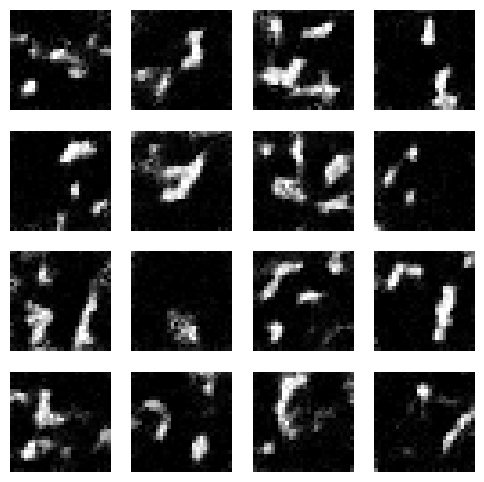

In [ ]:
# Model Instantiation and Training Loop
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 5 # You can adjust the number of epochs

print("Starting training...")
for epoch in range(epochs):
    model.train()
    # Using tqdm for a progress bar during training
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device)
        xt, noise = forward_diffusion(x, t)

        noise_pred = model(xt, t)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1} completed, Loss: {loss.item():.4f}")


# Image Generation (Sampling) Function
@torch.no_grad()
def sample(model, n_samples=16):
    model.eval()
    x = torch.randn(n_samples, 1, 28, 28).to(device)

    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        noise_pred = model(x, t_batch)

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x) # No noise on the last step

        # Reverse diffusion step
        x = (1 / torch.sqrt(alpha[t])) * (
            x - ((1 - alpha[t]) / torch.sqrt(1 - alpha_hat[t])) * noise_pred
        ) + torch.sqrt(beta[t]) * noise

    return x


# Display Generated Images
print("Generating samples...")
samples = sample(model)
samples = (samples.clamp(-1, 1) + 1) / 2 # Scale samples to [0, 1] for display

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i][0].cpu(), cmap="gray")
    plt.axis("off")
plt.show()

STEP 5 - DIGIT CLASSIFICATION MODEL

In [ ]:
#

class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)   # flatten image
        x = F.relu(self.fc1(x))
        return self.fc2(x)



classifier = MNISTClassifier().to(device)
clf_optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
clf_loss = nn.CrossEntropyLoss()



In [ ]:
# STEP 8 - TRAIN CLASSIFIER ON REAL MNIST

epochs = 3

for epoch in range(epochs):
    classifier.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        preds = classifier(images)
        loss = clf_loss(preds, labels)

        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()

        total_loss += loss.item()

    print(f"Classifier Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")


Classifier Epoch 1 Loss: 0.4317
Classifier Epoch 2 Loss: 0.2338
Classifier Epoch 3 Loss: 0.1722


STEP 9 - PERFORMANCE EVALUATION ON GENERATED IMAGES

In [ ]:


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

classifier.eval()

# Generate images
generated_images = sample(model, 100).to(device)

# Classifier predictions
predicted_labels = classifier(generated_images).argmax(dim=1)

# Fake ground truth (random digits)
true_labels = torch.randint(0, 10, (100,), device=device)

# Convert to numpy
y_true = true_labels.cpu().numpy()
y_pred = predicted_labels.cpu().numpy()

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print("Evaluation Metrics on Generated Images:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Evaluation Metrics on Generated Images:
Accuracy: 0.12
Precision: 0.11850193665983137
Recall: 0.13585470085470086
F1 Score: 0.11083778635552091
